# 4-1_決定木による戸建ての価格予測
このノートブックでは、決定木で回帰の予測モデルを作成します。

予測を行うテーマは線形回帰の演習で予測をした戸建て物件の価格を予測することです。

決定木は回帰にも分類にも用いることができ、用途に応じて以下の二つのモデルを使い分けます。
- 回帰：sklearn.tree.DecisionTreeRegressor
- 分類：sklearn.tree.DecisionTreeClassifier

[決定木のAPIドキュメント](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)

## ライブラリのインポート

In [2]:
# データを処理するための基本的なライブラリ
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
# 決定木モデルをインポート
from sklearn.tree import DecisionTreeRegressor
# 決定木を可視化したい場合はplot_treeもインポートする
from sklearn.tree import plot_tree

In [4]:
# matplotlibで日本語表示するための設定
!pip install japanize_matplotlib
import japanize_matplotlib

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'c:\program files\python39\python.exe -m pip install --upgrade pip' command.


そのほかGoogle Colaboratory上での出力のデフォルト設定をしておくと、結果を確認しやすくなるので、ここで設定しておきます。

In [5]:
# pandasのDataframeの出力
pd.set_option('display.max_columns', 500) # 表示列の最大
pd.set_option('display.max_rows', 500) # 表示行の最大
pd.set_option('display.unicode.east_asian_width', True) # 日本語出力時にヘッダのずれを解消
pd.options.display.float_format = '{:,.5f}'.format # 表示桁数の設定

# ノートブックの表示桁数設定。この設定はprint文には作用せず、セルの最後に書いたものを出力する際に適用されます。
%precision 3
# numpy配列の指数表示禁止設定
np.set_printoptions(suppress=True)
# numpy配列の表示桁数設定
np.set_printoptions(precision=3)

## データの準備


#### データを取り込む
- pandasのread_csvメソッドを使用して、mlho/data/totsuka_kodate.csvファイルを読み込みます
- 読み込んだものは変数totsuka_kodateに代入します

In [6]:
totsuka_kodate = pd.read_csv(r"C:\Users\fujitama\OneDrive - トレノケート株式会社\ドキュメント\コース開発\JTIS様向けMLHO\SSDSE-B-2009_2019.csv", encoding="shift-jis")

#### データを確認する

In [7]:
# 読み込んだデータを確認（すでに確認済みのデータなのでheadのみ）
#totsuka_kodate = totsuka_kodate[1:]
totsuka_kodate.head(2)

,年度,地域コード,都道府県,総人口,総人口（男）,総人口（女）,日本人人口,日本人人口（男）,日本人人口（女）,15歳未満人口,15歳未満人口（男）,15歳未満人口（女）,15〜64歳人口,15〜64歳人口（男）,15〜64歳人口（女）,65歳以上人口,65歳以上人口（男）,65歳以上人口（女）,出生数,出生数（男）,出生数（女）,合計特殊出生率,死亡数,死亡数（男）,死亡数（女）,転入者数（日本人移動者）,転入者数（日本人移動者）（男）,転入者数（日本人移動者）（女）,転出者数（日本人移動者）,転出者数（日本人移動者）（男）,転出者数（日本人移動者）（女）,婚姻件数,離婚件数,年平均気温,最高気温（日最高気温の月平均の最高値）,最低気温（日最低気温の月平均の最低値）,降水日数（年間）,降水量（年間）,着工建築物数,着工建築物床面積,旅館営業施設数（ホテルを含む）,旅館営業施設客室数（ホテルを含む）,標準価格（平均価格）（住宅地）,標準価格（平均価格）（商業地）,幼稚園数,幼稚園教員数,幼稚園在園者数,小学校数,小学校教員数,小学校児童数,中学校数,中学校教員数,中学校生徒数,中学校卒業者数,中学校卒業者のうち進学者数,高等学校数,高等学校教員数,高等学校生徒数,高等学校卒業者数,高等学校卒業者のうち進学者数,短期大学数,大学数,短期大学教員数,大学教員数,短期大学学生数,大学学生数,短期大学卒業者数,短期大学卒業者のうち進学者数,大学卒業者数,大学卒業者のうち進学者数,専修学校数,各種学校数,専修学校生徒数,各種学校生徒数,新規求職申込件数（一般）,月間有効求職者数（一般）,月間有効求人数（一般）,充足数（一般）,就職件数（一般）,一般旅券発行件数,延べ宿泊者数,外国人延べ宿泊者数,着工新設住宅戸数,着工新設持家数,着工新設貸家数,着工新設分譲住宅数,着工新設住宅床面積,着工新設持家床面積,着工新設分譲住宅床面積,着工新設貸家床面積,ごみ総排出量（総量）,1人1日当たりの排出量,ごみのリサイクル率,一般病院数,一般診療所数,歯科診療所数,保育所等数,保育所等定員数,保育所等利用待機児童数,保育所等在所児数,保育所等保育士数,消費支出（二人以上の世帯）,食料費（二人以上の世帯）,住居費（二人以上の世帯）,光熱・水道費（二人以上の世帯）,家具・家事用品費（二人以上の世帯）,被服及び履物費（二人以上の世帯）,保健医療費（二人以上の世帯）,交通・通信費（二人以上の世帯）,教育費（二人以上の世帯）,教養娯楽費（二人以上の世帯）,その他の消費支出（二人以上の世帯）
0,2019,R01000,北海道,5259000,2480000,2780000,5223000,2464000,2759000,565000,289000,276000,3012000,1484000,1528000,1673000,699000,973000,31020,15988,15032,1.24000,65498,33134,32364,47737,28614,19123,55467,31526,23941,23417,9833,9.80000,26.50000,-5.90000,131,814.00000,21463,4943285,2863,115751,19200,83700,404,4914,45449,1027,19145,239792,595,11679,124575,42181,40456,277,10337,123112,39976,19067,15,37,296,6683,4705,78612,2294,330,16702,2128,164,49,24958,3564,185269,696218,851537,39557,40059,119613,32197700,7975750,32486,11821,15625,4707,2776067,1444004,465364,843404,1850519,960,23.20000,484,3397,2884,1020,82008,152,76397,9837,294682,72912,20862,26332,9895,10466,16466,42277,8848,29335,57289
1,2018,R01000,北海道,5293000,2495000,2798000,5262000,2482000,2780000,577000,295000,282000,3052000,1502000,1551000,1656000,692000,964000,32642,16681,15961,1.27000,64187,32757,31430,47269,28263,19006,55222,31407,23815,22916,9971,9.50000,25.70000,-7.60000,157,"1,282.00000",21437,5192636,2868,111049,19000,78200,422,4995,48586,1045,19108,243511,597,11673,126986,43997,42428,280,10444,125164,40223,18569,16,38,293,6707,5013,78122,2415,344,16831,2112,168,49,25820,3780,200363,734530,870195,43961,44510,111793,30401200,7689550,35761,11740,19535,4067,2934844,1445452,415385,1041957,1875810,969,23.90000,486,3392,2905,1003,80564,129,76931,10221,281054,69044,19089,27012,8845,11517,11437,39308,10825,26991,56984


#### 説明変数、目的変数を切り出す
- 説明変数は「'築年数','最寄駅距離（分）','延床面積（㎡）','面積（㎡）','前面道路幅員（ｍ）','地区名', '前面道路種類', '土地の形状'」をダミー変数化して選択
- 目的変数は「'取引価格'」を選択

In [29]:
x = pd.get_dummies( totsuka_kodate[['ごみのリサイクル率']])

In [30]:
x.head(2)

,ごみのリサイクル率
0,23.20000
1,23.90000


In [31]:
y = totsuka_kodate['出生数']

In [32]:
y.head(2)

0    31020
1    32642
Name: 出生数, dtype: int64

#### データを訓練データとテストデータに分割する
**本研修でtotsuka_kodateデータセットを使用する際には、訓練データ70%、random_state=8で固定しています。他のモデルとの比較をしやすくするためです**

In [33]:
# 訓練データと検証データに分割(70%を訓練用に使用)
train_x, val_x, train_y, val_y = train_test_split(x, y, train_size=0.7, test_size=0.3, random_state=8)

決定木系のモデルではスケールを調整する必要は基本的にありません。決定木は値の大小だけで判断を行うためです。

## モデルの定義

In [34]:
model = DecisionTreeRegressor(random_state=0)

## モデルの学習

In [35]:
model.fit(train_x,train_y)

DecisionTreeRegressor(random_state=0)

## 作成された決定木を可視化する
学習したモデルで精度を評価する前に学習により作成された、決定木を可視化してみます。<br>
木を可視化することで何が重要な説明変数だったのかのヒントを得ることができるかもしれません。

可視化をする方法はいくつかありますが、今回はscikit-learnのplot_treeメソッドを用います。

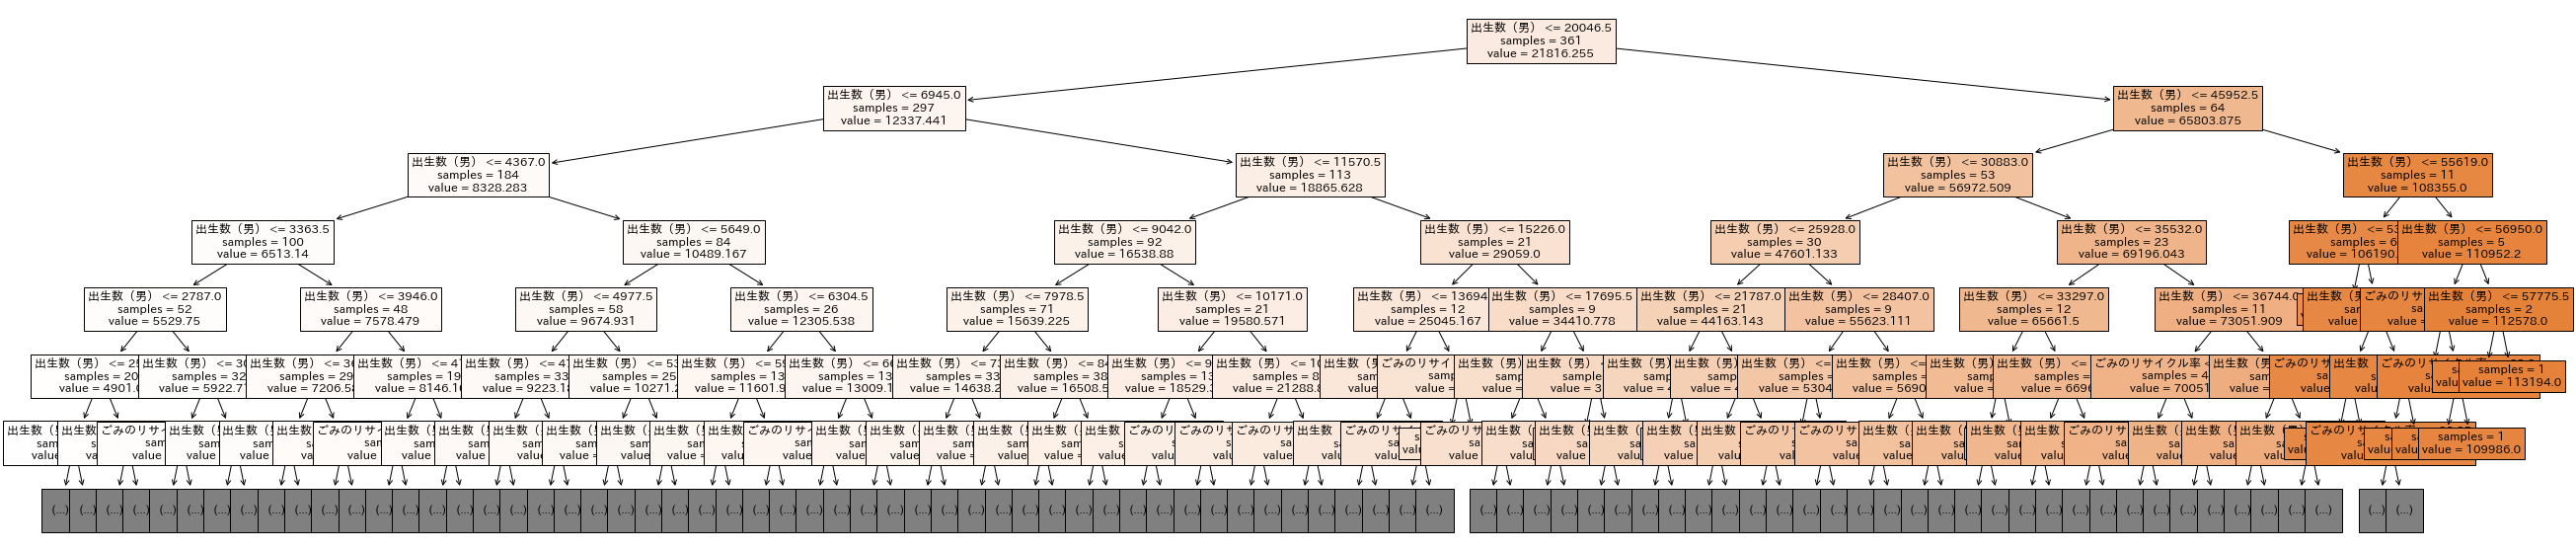

In [15]:
# 決定木の可視化を行う
# matplotlibで画像サイズの調整（横幅、縦幅）
plt.figure(figsize=(45,10))
# 描画と設定
plot_tree(
    model, # 可視化するモデルを指定
    max_depth=6, # 可視化する木の深さ
    feature_names = train_x.columns, # 分割するときの説明変数名を設定
    filled=True, # 色を付ける場合はTrue
    fontsize=12,
    impurity=False # ジニ不純度(どれくらい分類できていないかどうか)を表示するかどうか
    )
#matplotlibで保存
#plt.savefig("tree.pdf")
plt.show()  # 結果を表示する

多くの分岐があり、一見すると何が大事なのかわかりにくいですが、特に多くのサンプルを分割できている条件は重要な特徴量（説明変数）である可能性があります。<br>
これはなぜその物件が高いのか安いのかということを理由付ける条件を推察することに役立ちます。

## 評価

In [36]:
# 訓練データで精度を確認してみる
model.score(train_x, train_y)

0.518552165722346

In [37]:
# 検証データで精度を確認してみる
model.score(val_x, val_y)

-0.08660527323513278

In [38]:
# 訓練データで予測し、そのうち最初の5件だけを表示する
model.predict(train_x)[:5]

array([ 8669.5, 23413.6, 31968.2,  8446. , 63899.5])

In [19]:
# 正解を確認してみる
train_y.values[:5]

array([  6712,   9126,  22896,   8446, 108135], dtype=int64)

In [20]:
# 検証データで予測し、最初の5件だけを表示する
model.predict(val_x)[:5]

array([ 7042., 22150.,  6811.,  6811., 45387.])

In [21]:
# 正解を確認してみる
val_y.values[:5]

array([ 6846, 21234,  6651,  6899, 46084], dtype=int64)

決定木は、予測を説明しやすいことが大きな長所ですが、デフォルトの設定ではトレーニングデータに完全に適合するまで木を作り続けてしまうため、訓練データの特徴に過剰に適合し汎用性がない状態になってしまう過学習を起こしやすい欠点があります。

次は、決定木の過学習を緩和させるためにハイパーパラメータを調整してみます。

# 決定木モデルのパラメータチューニング

決定木の過学習を抑制するために、モデルを学習する際の詳細設定を行うハイパーパラメータを調整します。

決定木のハイパーパラメータのうち特に重要なハイパーパラメータは以下の3つです
- **max_depth:**決定木の最大の深さ
- **min_sample_leaf:**葉ノード（木の先端）に分類される最小のサンプル数。この数を下回らないようになる。
- **max_leaf_nodes:**葉ノードの総数

主には上のハイパーパラメータのうち1つか2つを調整するケースが多いです。そのほかのハイパーパラメータについては以下の公式リファレンスに記載があります。<br>
[決定木のAPIリファレンス](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.tree)

In [22]:
# ハイパーパラメータを変えて、精度の変化を確認してみましょう
# 今回はmax_depthを変更してみます
model = DecisionTreeRegressor(max_depth = 20, random_state=0)
model.fit(train_x,train_y)

DecisionTreeRegressor(max_depth=20, random_state=0)

In [23]:
# 訓練データで精度を確認してみる
model.score(train_x, train_y)

1.0

In [24]:
# 検証データで精度を確認してみる
model.score(val_x, val_y)

0.9993968101770683

In [25]:
# 訓練データで予測し、そのうち最初の5件だけを表示する
model.predict(train_x)[:5]

array([  6712.,   9126.,  22896.,   8446., 108135.])

In [26]:
# 正解を確認してみる
train_y.values[:5]

array([  6712,   9126,  22896,   8446, 108135], dtype=int64)

In [27]:
# 検証データで予測し、最初の5件だけを表示する
model.predict(val_x)[:5]

array([ 7042., 22150.,  6811.,  6811., 45387.])

In [28]:
# 正解を確認してみる
val_y.values[:5]

array([ 6846, 21234,  6651,  6899, 46084], dtype=int64)

**※ 調整例**

`model = DecisionTreeRegressor(max_depth=5, random_state=0)`

過学習を抑制して43%程の精度が出ます。

## 特徴量（説明変数）の重要度を確認する
決定木は木の作成に使われた特徴量（説明変数）のうち重要なものが何であったかを定量的に出力することもできます。<br>
需要な特徴量を把握することは実務上でも役立ちますし、他のモデルを用いるときにどの特徴量を使うのが有効なのかを判断することにも役立ちます。

In [ ]:
# 特徴量重要度
importances= model.feature_importances_
importances

In [ ]:
# DataFrameに整形して出力
# dataを特徴量重要度に設定し、行のインデックスを説明変数の列名にする
df_importances =pd.DataFrame(data=importances, index=train_x.columns)
df_importances

In [ ]:
# 特徴量重要度（0番目の列）でソートする。ascending=Falseで降順に並び替える
df_importances.sort_values(0, ascending=False)

In [ ]:
# （参考）matplotlibで棒グラフにする
plt.figure(figsize=(10,12))   # グラフのサイズ
n_features = train_x.shape[1] # 特徴量の数
plt.barh(range(n_features), model.feature_importances_, align='center') # x軸に特徴量、y軸に重要度を表示して中央寄せ（横棒グラフなので、x,yが逆）
plt.yticks(np.arange(n_features), train_x.columns) # x軸に項目名を表示
plt.plot;                     # グラフを表示

完全に0の特徴量もありますが、これは一度も木の作成に用いられなかった特徴量です。これらは全く役に立たないわけではなく、今回は木の作成に採用されなかっただけだということにも注意してください。<br>
のちに出てくるランダムフォレストや勾配ブースティング木の方がより偏りなく見ることができます。

このノートブックは以上です。